In [4]:
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import model
from tqdm import tqdm
from torchvision import datasets
from scipy.stats import norm
from torch.utils.data import DataLoader
from torchvision.utils import save_image

from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')

In [5]:
losses_train = []
losses_val = []
i_score_train = []
i_score_val=[]

In [6]:
# construct the argument parser and parser the arguments
# parser = argparse.ArgumentParser()
# parser.add_argument('-e', '--epochs', default=10, type=int, 
#                     help='number of epochs to train the VAE for')
# args = vars(parser.parse_args())

In [7]:
#Learning parameters
epochs = 10
batch_size = 256
lr = 0.0002
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [8]:
# transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
torch.Size([14000,28,28])
val_data = datasets.MNIST(
    root='../input/data',
    train=False,
    download=True,
    transform=transform
)
torch.Size([6000,28,28])
# training and validation data loaders
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False
)

In [9]:
model = model.LinearVAE().to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

LinearVAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)


In [39]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     print(KLD.item())
#     sum_kld = KLD.sum(axis=1)
    avg_kld = np.mean(KLD.item())
    i_score = np.exp(avg_kld)
    return BCE + KLD, i_score

In [23]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    inception_score = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, _ = data
        data = data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss,inception_score = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    losses_train.append(train_loss)
    i_score_train.append(inception_score)
    return train_loss

In [24]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    inception_score = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, _ = data
            data = data.to(device)
            data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss,inception_score = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(val_data)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction.view(batch_size, 1, 28, 28)[:8]))
                save_image(both.cpu(), f"../outputs/output{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    losses_val.append(val_loss)
    i_score_val.append(inception_score)
    return val_loss

In [40]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

  1%|█                                                                                 | 3/234 [00:00<00:09, 23.45it/s]

Epoch 1 of 10


  9%|███████▌                                                                         | 22/234 [00:00<00:05, 35.94it/s]<ipython-input-39-7ecc962c0675>:15: RuntimeWarning: overflow encountered in exp
  i_score = np.exp(avg_kld)
235it [00:05, 44.32it/s]                                                                                               
40it [00:00, 47.18it/s]                                                                                                
  1%|█                                                                                 | 3/234 [00:00<00:08, 28.87it/s]

Train Loss: 236.4208
Val Loss: 191.2523
Epoch 2 of 10


235it [00:05, 44.18it/s]                                                                                               
40it [00:00, 47.63it/s]                                                                                                
  2%|█▍                                                                                | 4/234 [00:00<00:07, 31.53it/s]

Train Loss: 180.9674
Val Loss: 174.6276
Epoch 3 of 10


235it [00:05, 43.76it/s]                                                                                               
40it [00:00, 51.58it/s]                                                                                                
  2%|█▍                                                                                | 4/234 [00:00<00:07, 31.27it/s]

Train Loss: 171.8795
Val Loss: 168.9068
Epoch 4 of 10


235it [00:05, 43.99it/s]                                                                                               
40it [00:00, 51.05it/s]                                                                                                
  2%|█▍                                                                                | 4/234 [00:00<00:06, 33.36it/s]

Train Loss: 167.4612
Val Loss: 165.7983
Epoch 5 of 10


235it [00:05, 42.76it/s]                                                                                               
40it [00:00, 51.58it/s]                                                                                                
  2%|█▍                                                                                | 4/234 [00:00<00:06, 33.35it/s]

Train Loss: 164.4430
Val Loss: 163.0300
Epoch 6 of 10


235it [00:05, 39.36it/s]                                                                                               
40it [00:00, 40.26it/s]                                                                                                
  2%|█▍                                                                                | 4/234 [00:00<00:07, 31.27it/s]

Train Loss: 162.4254
Val Loss: 161.7179
Epoch 7 of 10


235it [00:05, 41.69it/s]                                                                                               
40it [00:00, 48.11it/s]                                                                                                
  2%|█▍                                                                                | 4/234 [00:00<00:07, 31.26it/s]

Train Loss: 160.9419
Val Loss: 160.5296
Epoch 8 of 10


235it [00:05, 42.29it/s]                                                                                               
40it [00:00, 50.04it/s]                                                                                                
  2%|█▍                                                                                | 4/234 [00:00<00:06, 33.36it/s]

Train Loss: 159.7183
Val Loss: 159.5294
Epoch 9 of 10


235it [00:05, 40.54it/s]                                                                                               
40it [00:00, 49.54it/s]                                                                                                
  2%|█▍                                                                                | 4/234 [00:00<00:07, 31.27it/s]

Train Loss: 158.6250
Val Loss: 158.3846
Epoch 10 of 10


235it [00:05, 40.28it/s]                                                                                               
40it [00:01, 35.23it/s]                                                                                                

Train Loss: 157.5973
Val Loss: 157.5556


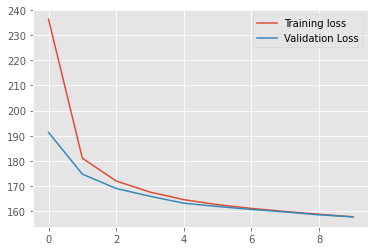

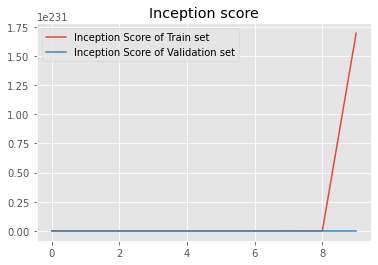

In [48]:
plt.figure()
plt.plot(losses_train, label='Training loss')
plt.plot(losses_val, label='Validation Loss')
plt.legend()
plt.savefig('VAE_outputs/VAEloss.png')

plt.figure()
plt.plot(i_score_train, label = "Inception Score of Train set")
plt.plot(i_score_val, label = "Inception Score of Validation set")
plt.title("Inception score")
plt.legend()
#plt.show()
plt.savefig('VAE_outputs/ISloss.png')

In [42]:
i_score_train

[1.3820262115032243e+119,
 3.6898451640232145e+181,
 1.8267382112091771e+196,
 4.615673968741475e+219,
 1.9451313953153009e+226,
 2.5435422024036215e+214,
 9.363608002199595e+208,
 7.563709593260374e+226,
 4.635463546796608e+208,
 1.694941464258712e+231]

In [43]:
i_score_val

[2.9057509197555435e+29,
 6.554291945641369e+39,
 2.8403723349224016e+40,
 9.067438376652991e+39,
 7.374387176908738e+38,
 3.472958494111199e+38,
 1.1347535764237511e+38,
 1.0612956417423575e+38,
 1.031428337241723e+37,
 7.058489062471674e+37]

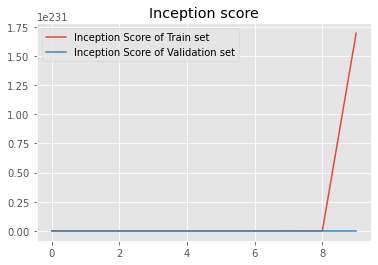

In [46]:
plt.figure()
plt.plot(i_score_train, label = "Inception Score of Train set")
plt.plot(i_score_val, label = "Inception Score of Validation set")
plt.title("Inception score")
plt.legend()
#plt.show()
plt.savefig('VAE_outputs/ISloss.png')